In [1]:
import logging

import torch
import torch.optim as optim

from robustbench.data import load_cifar10c
from robustbench.model_zoo.enums import ThreatModel
from robustbench.utils import load_model
from nets import *

import time
import tent
import norm
import oracle
from utils import *
from matplotlib import pyplot as plt


import ipdb

from conf import cfg, load_cfg_fom_args, merge_from_file

corruption_list = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness',
                        'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']


In [2]:
logger = logging.getLogger(__name__)
#TODO: build multistage.yaml
merge_from_file('cfgs/multistage.yaml')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### adaptation 없이 initial high_entropy samples, low_entropy samples index 찾기

In [3]:
def setup_tent(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    tent_model = tent.Tent(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return tent_model

def setup_optimizer(params):
    """Set up optimizer for tent adaptation.

    Tent needs an optimizer for test-time entropy minimization.
    In principle, tent could make use of any gradient optimizer.
    In practice, we advise choosing Adam or SGD+momentum.
    For optimization settings, we advise to use the settings from the end of
    trainig, if known, or start with a low learning rate (like 0.001) if not.

    For best results, try tuning the learning rate and batch size.
    """
    if cfg.OPTIM.METHOD == 'Adam':
        return optim.Adam(params,
                    lr=cfg.OPTIM.LR,
                    betas=(cfg.OPTIM.BETA, 0.999),
                    weight_decay=cfg.OPTIM.WD)
    elif cfg.OPTIM.METHOD == 'SGD':
        return optim.SGD(params,
                   lr=cfg.OPTIM.LR,
                   momentum=cfg.OPTIM.MOMENTUM,
                   dampening=cfg.OPTIM.DAMPENING,
                   weight_decay=cfg.OPTIM.WD,
                   nesterov=cfg.OPTIM.NESTEROV)
    else:
        raise NotImplementedError
    
def setup_source(model):
    """Set up the baseline source model without adaptation."""
    model.eval()
    logger.info(f"model for evaluation: %s", model)
    return model

In [6]:

# configure model

# for WRN-40-2
# base_model = load_model(cfg.MODEL.ARCH, cfg.CKPT_DIR,
#                     cfg.CORRUPTION.DATASET, ThreatModel.corruptions).to(device)

# for ResNet18
base_model = ResNet18(n_classes=10)
ckpt = torch.load("/home2/wonjae.roh/nprc/tent/ckpt/cifar10/corruptions/ResNet18_pretrained.pth.tar", map_location=device)
base_model.load_state_dict(ckpt["pretrain-learner"])


x_test, y_test = load_cifar10c(cfg.CORRUPTION.NUM_EX, cfg.CORRUPTION.SEVERITY[0], cfg.DATA_DIR, False, cfg.CORRUPTION.TYPE)
x_test, y_test = x_test.to(device), y_test.to(device)

acc, outputs = get_stats(base_model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True)



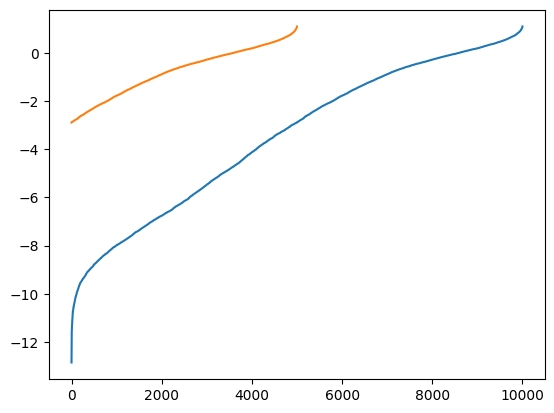

In [7]:
%matplotlib inline

entropy = tent.softmax_entropy(outputs)
entropy = torch.log2(entropy)
entropy_sorted, entropy_sorted_index = entropy.sort()
plt.plot(entropy_sorted.numpy())

high_index = entropy_sorted_index[5000:]
low_index = entropy_sorted_index[:5000]
high_values = entropy[high_index]
low_values = entropy[low_index]
plt.plot(high_values.numpy())

### Correct samples, Wrong samples entropy histogram visualize

                 0
count  6650.000000
mean     -4.490295
std       3.051584
min     -12.851545
25%      -7.051768
50%      -4.654674
75%      -1.754242
max       1.014240
                 0
count  3350.000000
mean     -1.380728
std       2.067541
min     -10.295475
25%      -2.323641
50%      -0.614414
75%       0.114200
max       1.095908


(array([  3.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   2.,   2.,
          2.,   2.,   3.,   2.,   2.,   1.,   4.,   3.,   2.,   2.,   5.,
          5.,   4.,   2.,   7.,   5.,   6.,   9.,   8.,  10.,   4.,   8.,
         11.,  13.,   9.,  11.,   6.,   8.,   9.,  13.,  12.,  11.,  13.,
         18.,  14.,  20.,  12.,  16.,  19.,  12.,  12.,  17.,  26.,  24.,
         15.,  25.,  19.,  25.,  24.,  27.,  29.,  27.,  28.,  42.,  32.,
         30.,  27.,  39.,  37.,  34.,  45.,  45.,  31.,  50.,  55.,  49.,
         52.,  57.,  69.,  50.,  71.,  63.,  76.,  91.,  93., 114., 124.,
        131., 157., 165., 170., 151., 150., 126.,  96.,  82.,  61.,  33.,
         20.]),
 array([-10.29547501, -10.18156147, -10.06764698,  -9.95373344,
         -9.83981991,  -9.72590542,  -9.61199188,  -9.49807835,
         -9.38416481,  -9.27025032,  -9.15633678,  -9.04242325,
         -8.92850876,  -8.81459522,  -8.70068169,  -8.5867672 ,
         -8.47285366,  -8.35894012,  -8.24502659,  -8.1311121 

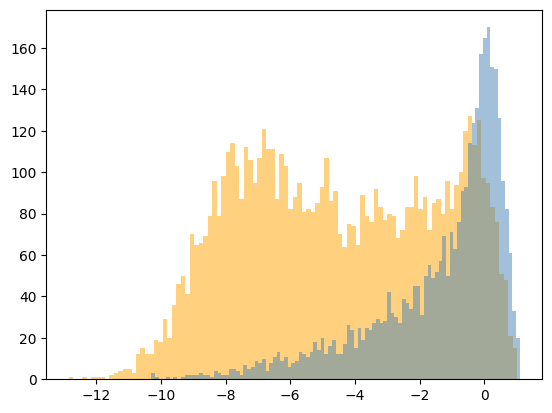

In [8]:
import pandas as pd

data_dir = "/gallery_tate/wonjae.roh/cifar10c"
labels_path = data_dir + '/labels.npy'
labels = np.load(labels_path)
# labels는 10000 sample, 5 severity에 대해 10000개의 같은 label이 5번 반복되는 형태이므로 잘라준다
labels = labels[:10000]

predicted = outputs.argmax(axis=1).numpy()

correct = predicted==labels
wrong = ~correct
entropy_numpy = entropy.numpy()

correct_entropy = entropy_numpy[correct]
wrong_entropy = entropy_numpy[wrong]

correct_describe = pd.DataFrame(correct_entropy)
print(correct_describe.describe())
wrong_describe = pd.DataFrame(wrong_entropy)
print(wrong_describe.describe())

plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [10]:
threshold = entropy_sorted[5000].item()
print(f'threshold : {threshold:.4f}') 

correct_high = np.sum(correct_describe > threshold)
correct_low = np.sum(correct_describe < threshold)
wrong_high = np.sum(wrong_describe > threshold)
wrong_low = np.sum(wrong_describe < threshold)

print(f'high entropy accuracy : {correct_high / (correct_high + wrong_high)}') 
print(f'low entropy accuracy : {correct_low / (correct_low + wrong_low)}')

threshold : -2.8890
high entropy accuracy : 0    0.464893
dtype: float64
low entropy accuracy : 0    0.8652
dtype: float64


### Dataloader (low_entropy, high_entropy, all)

In [11]:
def get_subset(x, y, indices, shuffle=False):
    """get subset of data from indices
    Args:
    x: data
    y: labels
    indices: indices to get subset
    Returns:
    subset of data and labels
    """
    x_sub = x[indices]
    y_sub = y[indices]

    if shuffle:
        rand_idx = np.random.permutation(np.arange(len(x_sub)))
        x_sub, y_sub = x_sub[rand_idx], y_sub[rand_idx]

    return x_sub, y_sub
        
x_low, y_low = get_subset(x_test, y_test, low_index, shuffle=True)
x_high, y_high = get_subset(x_test, y_test, high_index, shuffle=True)     

### adaptation with suitable dataset (all)

In [12]:
def vis_entropy_histogram(outputs, labels):
    entropy = tent.softmax_entropy(outputs)
    entropy = torch.log2(entropy)
    entropy_numpy = entropy.numpy()
    labels = labels.numpy()

    predicted = outputs.argmax(axis=1).numpy()

    correct = predicted==labels
    wrong = ~correct

    correct_entropy = entropy_numpy[correct]
    wrong_entropy = entropy_numpy[wrong]


    correct_describe = pd.DataFrame(correct_entropy)
    print(correct_describe.describe())
    wrong_describe = pd.DataFrame(wrong_entropy)
    print(wrong_describe.describe())

    plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
    plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [13]:
if cfg.MODEL.ADAPTATION == "tent":
    logger.info("test-time adaptation: TENT")
    model = setup_tent(base_model)
elif cfg.MODEL.ADAPTATION == "source":
    logger.info("test-time adaptation: SOURCE")
    model = setup_source(base_model)

In [14]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_total, outputs_total = get_stats(model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'error : {(1-acc_total):.4f}')  

error : 0.2776


### adaptation with suitable dataset (low)

In [15]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'low_error : {(1-acc_low):.4f}')  

# without updating, check on high entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'high_error : {(1-acc_high):.4f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total):.4f}') 


low_error : 0.1334
high_error : 0.3934
total_error : 0.2634


                 0
count  4333.000000
mean     -6.448487
std       2.006079
min     -14.244494
25%      -7.813670
50%      -6.674402
75%      -5.275509
max       0.466659
                0
count  667.000000
mean    -4.307582
std      2.285347
min    -13.045994
25%     -5.904628
50%     -4.229180
75%     -2.635986
max      0.140487


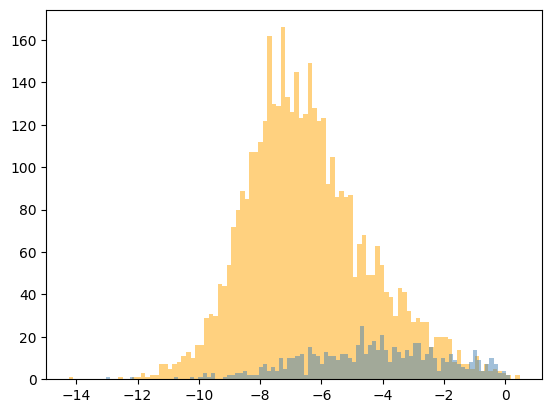

In [16]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  3033.000000
mean     -4.521664
std       3.369215
min     -14.939487
25%      -7.129809
50%      -4.210942
75%      -1.483109
max       0.710796
                 0
count  1967.000000
mean     -1.902412
std       2.343736
min     -12.517230
25%      -2.911730
50%      -1.042783
75%      -0.257568
max       0.933363


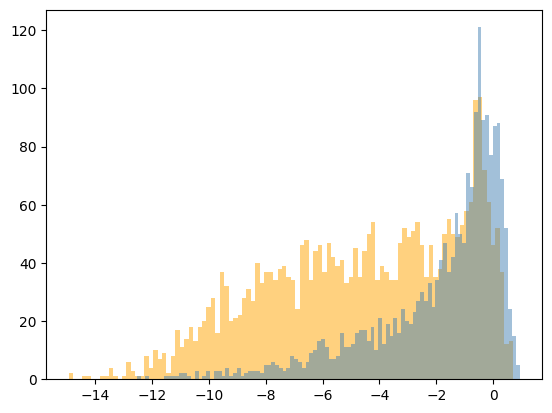

In [17]:
vis_entropy_histogram(outputs_high, y_high)

### adaptation with suitable dataset (high)

In [18]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'high_error : {(1-acc_high):.4f}')  

# without updating, check on high entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'low_error : {(1-acc_low):.4f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total):.4f}') 

high_error : 0.4438
low_error : 0.1200
total_error : 0.2819


                 0
count  4400.000000
mean     -7.742862
std       2.511152
min     -15.561669
25%      -9.364180
50%      -8.254502
75%      -6.642660
max       0.654680
                0
count  600.000000
mean    -4.106853
std      3.150130
min    -12.101429
25%     -6.598792
50%     -3.526718
75%     -1.162331
max      0.526268


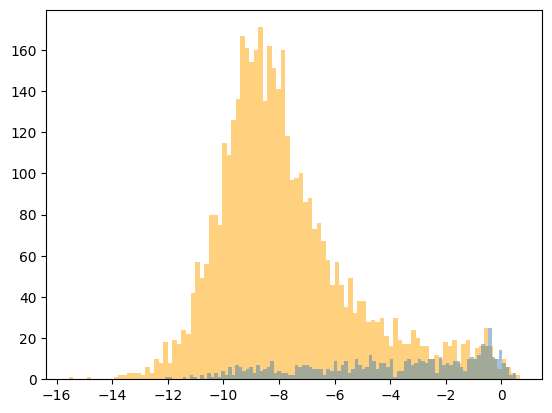

In [19]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  2781.000000
mean     -3.111423
std       2.661352
min     -11.658177
25%      -4.804503
50%      -2.608471
75%      -0.834647
max       0.910708
                 0
count  2219.000000
mean     -1.351082
std       1.883955
min     -10.798829
25%      -2.166139
50%      -0.683784
75%      -0.017225
max       1.025717


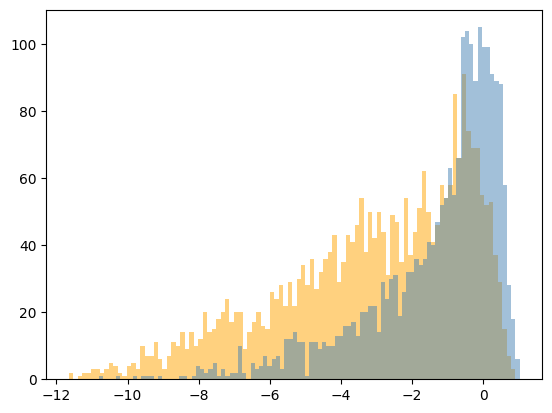

In [20]:
vis_entropy_histogram(outputs_high, y_high)

ResNet18 기준으로는 차이가 좀 나네